# Implementierung eines SNN und CNN: Ein Vergleich mit dem MNIST-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import time

Schritt 2: Cuda benutzen

In [2]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [3]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        surrogate_grad = torch.exp(-input.abs())  # Glatte Ableitung
        return grad_output * surrogate_grad

spike_fn = SurrogateSpike.apply

In [4]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0, tau_mem=10.0):
        super(SNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.v_rest = v_rest
        self.v_thresh = v_thresh
        self.v_reset = v_reset
        self.tau_mem = tau_mem

        self.synapse_weights = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape
        v_hidden = torch.full((batch_size, self.hidden_size), self.v_rest, device=x.device)
        spikes_out = torch.zeros(batch_size, time_steps, self.hidden_size, device=x.device)

        for t in range(time_steps):
            z_pre = x[:, t, :]  # (B, input_size)
            v_hidden += (self.v_rest - v_hidden) * (dt / self.tau_mem) + torch.matmul(z_pre, self.synapse_weights)
            z_post = spike_fn(v_hidden - self.v_thresh)
            v_hidden = torch.where(z_post > 0, torch.tensor(self.v_reset, device=x.device), v_hidden)
            spikes_out[:, t, :] = z_post

        spikes_sum = spikes_out.sum(dim=1)
        spikes_bn = self.batch_norm(spikes_sum)
        output = self.fc2(spikes_bn)
        return output

Schritt 4: MNIST-Datensatz laden

Test mit MNIST

Test mit Kanji-Datensatz

In [5]:
from torch.utils.data import Subset

batch_size = 32
time_steps = 50

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
subset_size = 900
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_subset_size = 100
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(test_subset_size))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.0):
    images = images.view(images.size(0), -1)  # (B, 3072)
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (images > threshold).float()
    return spikes

Schritt 5: CNN erstellen

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 Kanal (nicht 3!)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        # Feature Map-Größe nach 3x Pooling mit Kernel 2: 28 → 14 → 7 → 3 (eigentlich 3x3)
        self.fc1 = nn.Linear(64 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

        self.dropout = nn.Dropout(0.5)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 → 14x14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 → 7x7
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7x7 → 3x3

        x = x.view(x.size(0), -1)  # Flatten: 64 * 3 * 3
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [7]:
# Hyperparameter
input_size = 784
hidden_size = 3072
output_size = 10
epochs = 100
time_steps = 50

snn_model = SNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [9]:
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Spikes generieren
        spike_input = image_to_spikes(images, time_steps, threshold=0.0)

        # Forward + Loss
        outputs = snn_model(spike_input)
        loss = snn_loss_fn(outputs, labels)

        # Backward + Optimierung
        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 0.9356
Epoch 2 Loss: 0.1667
Epoch 3 Loss: 0.1446
Epoch 4 Loss: 0.0237
Epoch 5 Loss: 0.0255
Epoch 6 Loss: 0.0139
Epoch 7 Loss: 0.3699
Epoch 8 Loss: 0.4406
Epoch 9 Loss: 0.1846
Epoch 10 Loss: 0.2875
Epoch 11 Loss: 0.0598
Epoch 12 Loss: 0.1279
Epoch 13 Loss: 0.0063
Epoch 14 Loss: 0.7614
Epoch 15 Loss: 0.2472
Epoch 16 Loss: 0.0940
Epoch 17 Loss: 0.0195
Epoch 18 Loss: 0.0005
Epoch 19 Loss: 1.4516
Epoch 20 Loss: 0.0287
Epoch 21 Loss: 0.1833
Epoch 22 Loss: 0.3600
Epoch 23 Loss: 0.1041
Epoch 24 Loss: 0.0008
Epoch 25 Loss: 0.0057
Epoch 26 Loss: 1.5339
Epoch 27 Loss: 0.0371
Epoch 28 Loss: 0.0007
Epoch 29 Loss: 0.0005
Epoch 30 Loss: 0.2681
Epoch 31 Loss: 0.0417
Epoch 32 Loss: 0.4907
Epoch 33 Loss: 0.7911
Epoch 34 Loss: 0.4092
Epoch 35 Loss: 0.0163
Epoch 36 Loss: 0.0152
Epoch 37 Loss: 0.0185
Epoch 38 Loss: 0.2597
Epoch 39 Loss: 0.0003
Epoch 40 Loss: 2.4015
Epoch 41 Loss: 0.0073
Epoch 42 Loss: 0.0137
Epoch 43 Loss: 0.0289
Epoch 44 Loss: 0.0216
Epoch 45 Loss: 0.8992
Epoch 46 Loss: 1.01

In [10]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 850.95 Sekunden
Maximale GPU-Speichernutzung: 127.33 MB


8. CNN trainieren

In [11]:
# CNN trainieren
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        
        running_loss += cnn_loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/100], CNN Loss: 1.5957
Epoch [2/100], CNN Loss: 0.6279
Epoch [3/100], CNN Loss: 0.3081
Epoch [4/100], CNN Loss: 0.1850
Epoch [5/100], CNN Loss: 0.1448
Epoch [6/100], CNN Loss: 0.0914
Epoch [7/100], CNN Loss: 0.0562
Epoch [8/100], CNN Loss: 0.0359
Epoch [9/100], CNN Loss: 0.0317
Epoch [10/100], CNN Loss: 0.0205
Epoch [11/100], CNN Loss: 0.0140
Epoch [12/100], CNN Loss: 0.0148
Epoch [13/100], CNN Loss: 0.0111
Epoch [14/100], CNN Loss: 0.0105
Epoch [15/100], CNN Loss: 0.0145
Epoch [16/100], CNN Loss: 0.0114
Epoch [17/100], CNN Loss: 0.0119
Epoch [18/100], CNN Loss: 0.0096
Epoch [19/100], CNN Loss: 0.0070
Epoch [20/100], CNN Loss: 0.0044
Epoch [21/100], CNN Loss: 0.0092
Epoch [22/100], CNN Loss: 0.0931
Epoch [23/100], CNN Loss: 0.0408
Epoch [24/100], CNN Loss: 0.0443
Epoch [25/100], CNN Loss: 0.0134
Epoch [26/100], CNN Loss: 0.0086
Epoch [27/100], CNN Loss: 0.0035
Epoch [28/100], CNN Loss: 0.0027
Epoch [29/100], CNN Loss: 0.0013
Epoch [30/100], CNN Loss: 0.0013
Epoch [31/100], CNN

In [12]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 1511.54 Sekunden
Maximale GPU-Speichernutzung: 127.33 MB


9. SNN Evaluieren

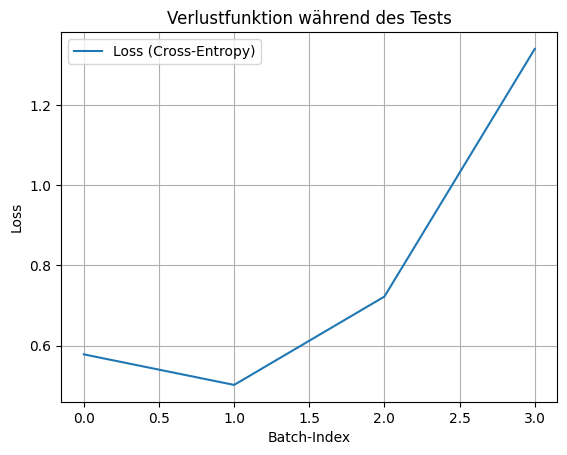

Accuracy (SNN): 89.00%
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.93      0.96        14
           2       0.73      1.00      0.84         8
           3       0.83      0.91      0.87        11
           4       0.93      0.93      0.93        14
           5       1.00      0.57      0.73         7
           6       1.00      0.90      0.95        10
           7       0.92      0.73      0.81        15
           8       0.50      1.00      0.67         2
           9       0.85      1.00      0.92        11

    accuracy                           0.89       100
   macro avg       0.88      0.90      0.87       100
weighted avg       0.91      0.89      0.89       100



In [13]:
from sklearn.metrics import classification_report
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f_oneway

snn_model.eval()
correct = 0
total = 0
loss_values = []

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps).to(device)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Wichtig: Auf CPU bringen und zu Listen hinzufügen
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy berechnen
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')

# Optional: target names, z. B. für KMNIST (0–9)
class_names = [str(i) for i in range(10)]

# Classification Report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
)

f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)


10. CNN Evaluieren

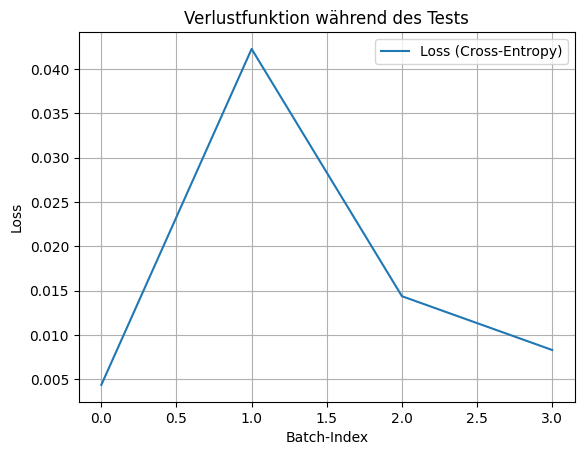

Accuracy (CNN): 99.00%
Precision (macro): 0.9889
Recall (macro):    0.9933
F1-Score (macro):  0.9907
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        14
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        10
           7       1.00      0.93      0.97        15
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00        11

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from matplotlib import pyplot as plt

loss_values = []
cnn_model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = cnn_loss_fn(outputs, labels)
        loss_values.append(loss.item())
    
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro):    {recall:.4f}')
print(f'F1-Score (macro):  {f1:.4f}')

report = classification_report(all_labels, all_preds, zero_division=0)
f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)
